# Test of CSV file produced using ROOT converter

In this notebook I'll test the macro, written in python, used for converting a ROOT structure (Tree) into a CSV file for ML analysis.

The CSV is located inside the directory output, created by the python macro **examplemacro.py**:

In [1]:
!ls ../MuonPOGAnalysisTemplate/

Jupyter_Notebooks_miscellaneous exampleMacro.py
MuonTree.root                   interface
README.md                       output
config                          results
exampleMacro                    tdrstyle.C
exampleMacro.C


In [2]:
%cd ../MuonPOGAnalysisTemplate/output
!head -5 output_bxcut.csv

/Users/tommaso/TESI_MAGISTRALE/MuonPOGAnalysisTemplate/output







To analyze it, we need the ROOT python module and pandas for the CSV analysis:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now we need to read the CSV:

In [4]:
df2 = pd.read_csv('./output_bxcut.csv')
df2

,Event,dtPrimitive.id_r,dtPrimitive.id_eta,dtPrimitive.id_phi,dtPrimitive.phiGlb(),dtPrimitive.phiB,dtPrimitive.quality,genParticle.pt
0,1,1,1,2,0.547525,-91.0,6,9.452828
1,1,2,1,2,0.519693,-71.0,6,9.452828
2,1,3,2,2,0.499429,-25.0,5,9.452828
3,1,4,2,2,0.489663,-22.0,6,9.452828
4,2,4,1,1,-0.322266,-3.0,6,164.478928
5,2,3,1,12,5.961246,-2.0,5,164.478928
6,3,1,0,4,1.816158,-10.0,6,91.713860
7,3,3,0,4,1.812007,-6.0,6,91.713860
8,3,4,0,4,1.811519,13.0,5,91.713860
9,4,2,-2,10,4.605700,-2.0,6,139.442352


We sort the dataframe with ascending order of sector primitive

In [5]:
df2 = df2.sort_values(["Event","dtPrimitive.id_r"])
df2 = df2.reset_index(drop=True)
#df2["dtPrimitive.phiB"] = df2["dtPrimitive.phiGlb()"] + df2["dtPrimitive.phiB"]/512.

### Change CSV structure for a suitable ML format

Using the following code, the structure of the input CSV changes. Instead of considering each line as a single primitive, now each line represents a single event (with multiple primitives structured by columns).

The main difference, therefore, is an increasing number of columns: one for each primitive.

In [6]:
a = 1
new_column = []
row_list=[]
final_row=[]
for column in df2.columns.values.tolist():
    if column==df2.columns.values.tolist()[0]:
        new_column.append(column)
        new_column.append("n_Primitive")
        continue
    for count in range(1,df2["Event"].value_counts().max()+1):
        if "()" in column:
            column = column.replace("()", "")
        new_column.append(str(count) + column)
        
df = pd.DataFrame(columns=new_column)
for index, row in df2.iterrows():
    if (row["Event"] == a):
        row_list.append(row.tolist())
        continue
    elif(row["Event"] != a):
        for i in range(0,len(df2.columns)):
            if i==0:
                final_row.append(row_list[0][0])
                final_row.append(len(row_list))
                continue
            for j in range(0,len(row_list)):
                final_row.append(row_list[j][i])
                if j == len(row_list)-1:   
                    if len(row_list) != df2["Event"].value_counts().max():
                        final_row += [0]*(df2["Event"].value_counts().max()-len(row_list))
        a = row["Event"]
        df.loc[row["Event"]-1] = final_row
        del row_list[:]
        del final_row[:]
        row_list.append(row.tolist())

for i in range(0,len(df2.columns)):
    if i==0:
        final_row.append(row_list[0][0])
        final_row.append(len(row_list))
        continue
    for j in range(0,len(row_list)):
        final_row.append(row_list[j][i])
        if j == len(row_list)-1:   
            if len(row_list) != df2["Event"].value_counts().max():
                final_row += [0]*(df2["Event"].value_counts().max()-len(row_list))
df.loc[row["Event"]] = final_row

In [7]:
df = df.rename(columns = {"1genParticle.pt":"genParticle.pt","1dtPrimitive.phiGlb()":"1dtPrimitive.phiGlb"})

In [8]:
for i in range(2,df2["Event"].value_counts().max()+1):
    title = str(i) + "genParticle.pt"
    df = df.drop(title,1)

In [9]:
for column in df.columns.values.tolist():
    if column[0] == '5':
        df = df.drop(column,axis=1)

Insert columns relative to delta phi angles between sectors.

In [10]:
cols = df.columns.values.tolist()
df.insert(len(cols)-1,"delta_phi34", abs(df["3dtPrimitive.phiGlb"]-df["4dtPrimitive.phiGlb"]))
df.insert(len(cols)-1,"delta_phi24", abs(df["2dtPrimitive.phiGlb"]-df["4dtPrimitive.phiGlb"]))
df.insert(len(cols)-1,"delta_phi23", abs(df["2dtPrimitive.phiGlb"]-df["3dtPrimitive.phiGlb"]))
df.insert(len(cols)-1,"delta_phi14", abs(df["1dtPrimitive.phiGlb"]-df["4dtPrimitive.phiGlb"]))
df.insert(len(cols)-1,"delta_phi13", abs(df["1dtPrimitive.phiGlb"]-df["3dtPrimitive.phiGlb"]))
df.insert(len(cols)-1,"delta_phi12", abs(df["1dtPrimitive.phiGlb"]-df["2dtPrimitive.phiGlb"]))

In [11]:
for column in df.columns.values.tolist():
    if "phiGlb" in column:
        df = df.drop(column,axis=1)

This line changes the status for the sector that receives a muon. Instead of using the number of radial sector, a binary value (0 or 1) is used. This should make the work much easier for the ML algorithm.

In [12]:
df = df[df.n_Primitive != 5.0]
df.loc[df["1dtPrimitive.id_r"] != 0, '1dtPrimitive.id_r'] = 1.0
df.loc[df["2dtPrimitive.id_r"] != 0, '2dtPrimitive.id_r'] = 1.0
df.loc[df["3dtPrimitive.id_r"] != 0, '3dtPrimitive.id_r'] = 1.0
df.loc[df["4dtPrimitive.id_r"] != 0, '4dtPrimitive.id_r'] = 1.0

This is the new csv table, using the new format.

In [13]:
df

,Event,n_Primitive,1dtPrimitive.id_r,2dtPrimitive.id_r,3dtPrimitive.id_r,4dtPrimitive.id_r,1dtPrimitive.id_eta,2dtPrimitive.id_eta,3dtPrimitive.id_eta,4dtPrimitive.id_eta,...,2dtPrimitive.quality,3dtPrimitive.quality,4dtPrimitive.quality,delta_phi12,delta_phi13,delta_phi14,delta_phi23,delta_phi24,delta_phi34,genParticle.pt
1.0,1.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,...,6.0,5.0,6.0,0.027832,0.048096,0.057861,0.020264,0.030029,0.009766,9.452828
2.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,6.0,0.0,0.0,6.283512,5.961246,5.961246,0.322266,0.322266,0.000000,164.478928
3.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,6.0,5.0,0.0,0.004150,0.004639,1.816158,0.000488,1.812007,1.811519,91.713860
4.0,4.0,4.0,1.0,1.0,1.0,1.0,-1.0,-2.0,-2.0,-2.0,...,6.0,6.0,2.0,0.001709,0.002441,0.002686,0.000732,0.000977,0.000244,139.442352
5.0,5.0,3.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,0.0,...,3.0,3.0,0.0,0.009277,0.017334,5.301661,0.026611,5.292384,5.318995,198.223480
6.0,6.0,1.0,1.0,0.0,0.0,0.0,-2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.432199,4.432199,4.432199,0.000000,0.000000,0.000000,47.726688
7.0,7.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,5.0,2.0,0.0,0.001221,0.002114,4.004464,0.000894,4.003243,4.002350,146.894150
8.0,8.0,4.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,6.0,6.0,6.0,0.001221,0.002197,0.002441,0.000977,0.001221,0.000244,149.884445
9.0,9.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,...,5.0,0.0,0.0,0.002197,1.042071,1.042071,1.039873,1.039873,0.000000,74.841820
10.0,10.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,5.0,5.0,6.0,0.000977,0.001709,0.002197,0.000732,0.001221,0.000488,159.808716


Let's plot a correlation matrix for each variable inside the csv:

In [14]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns,rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.imshow(corr, aspect=1)

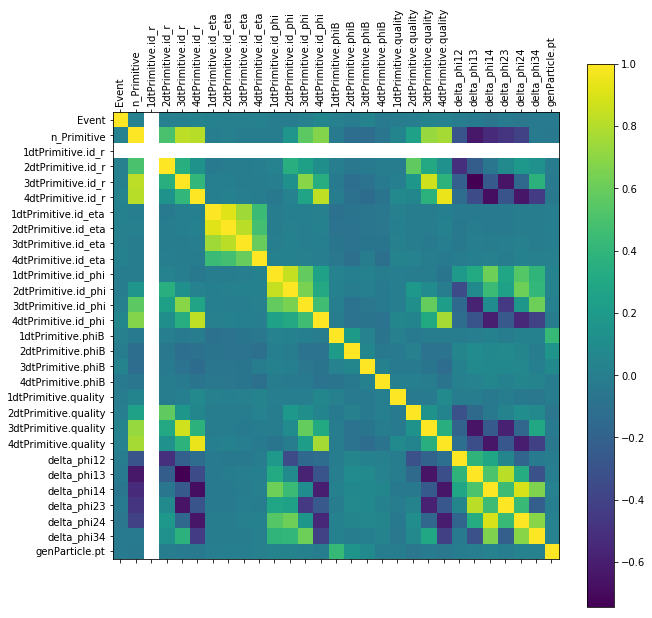

In [15]:
plot_corr(df)
plt.colorbar()
plt.show()

Then put the organized table inside a csv file.

In [16]:
df.to_csv("/Users/tommaso/TESI_MAGISTRALE/MuonPOGAnalysisTemplate/output/bxcut_org.csv",na_rep=0,index=False)